In [31]:
import pandas as pd
import numpy as np
import datetime
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns 
import geopandas as gpd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
stockx_data = pd.read_excel("./StockX-Data-Contest-2019.xlsx",sheet_name="Raw Data")

In [32]:
#Readable numbers
def readable_numbers(x): 
    if x > 1e9:
        s='{:1.1f}B'.format(x*1e-9)
    elif x > 1e6:
        s='{:1.1f}M'.format(x*1e-6)
    else:
        s='{:1.0f}K'.format(x*1e-3)
    return s

In [33]:
stockx_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99956 entries, 0 to 99955
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Order Date    99956 non-null  datetime64[ns]
 1   Brand         99956 non-null  object        
 2   Sneaker Name  99956 non-null  object        
 3   Sale Price    99956 non-null  float64       
 4   Retail Price  99956 non-null  int64         
 5   Release Date  99956 non-null  datetime64[ns]
 6   Shoe Size     99956 non-null  float64       
 7   Buyer Region  99956 non-null  object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 6.1+ MB


In [34]:
color = pd.read_excel("./supplemental_data_colorway.xlsx",sheet_name="Sheet1")

In [35]:
# --- Data Cleaning ---
# calculate price premium: (sale price - retail price)/retail price
stockx_data["Price_Percentage_change"] = (stockx_data['Sale Price'] - stockx_data['Retail Price'])/stockx_data['Retail Price']

# calculate days since release: order data - release date
stockx_data["Days_Since_Release"] = (pd.to_datetime(stockx_data['Order Date']) - pd.to_datetime(stockx_data['Release Date']))/np.timedelta64('1','D')

# --- style variables ---
# style: v2
stockx_data["yeezy"] = stockx_data['Sneaker Name'].apply(lambda x : 1 if 'Yeezy' in x.split("-") else 0)
# style: airjordan
stockx_data["airjordan"] = stockx_data['Sneaker Name'].apply(lambda x : 1 if 'Jordan' in x.split("-") else 0)
# style: airforce
stockx_data["airforce"] = stockx_data['Sneaker Name'].apply(lambda x : 1 if 'Force' in x.split("-") else 0)
# style: airmax90
stockx_data["airmax90"] = stockx_data['Sneaker Name'].apply(lambda x : 1 if '90' in x.split("-") else 0)
# style: airmax97
stockx_data["airmax97"] = stockx_data['Sneaker Name'].apply(lambda x : 1 if '97' in x.split("-") else 0)
# style: presto
stockx_data["presto"] = stockx_data['Sneaker Name'].apply(lambda x : 1 if 'Presto' in x.split("-") else 0)
# style: vapormax
stockx_data["vapormax"] = stockx_data['Sneaker Name'].apply(lambda x : 1 if 'VaporMax' in x.split("-") else 0)
# style: blazer
stockx_data["blazer"] = stockx_data['Sneaker Name'].apply(lambda x : 1 if 'Blazer' in x.split("-") else 0)
# style: zoom
stockx_data["zoom"] = stockx_data['Sneaker Name'].apply(lambda x : 1 if 'Zoom' in x.split("-") else 0)
# style: zoom
stockx_data["react"] = stockx_data['Sneaker Name'].apply(lambda x : 1 if 'React' in x.split("-") else 0)

# --- state variables ---
# creating the california variable
stockx_data["California"] = stockx_data["Buyer Region"].apply(lambda x : 1 if 'California' in x else 0)
# creating the new_york variable
stockx_data["New York"] = stockx_data["Buyer Region"].apply(lambda x : 1 if 'New York' in x else 0)
# creating the oregon variable
stockx_data["Oregon"] = stockx_data["Buyer Region"].apply(lambda x : 1 if 'Oregon' in x else 0)
# creating the florida variable
stockx_data["Florida"] = stockx_data["Buyer Region"].apply(lambda x : 1 if 'Florida' in x else 0)
# creating the texas variable
stockx_data["Texas"] = stockx_data["Buyer Region"].apply(lambda x : 1 if 'Texas' in x else 0)
# creating the other_state variable
above5pct_states = ["California", "New York", "Oregon", "Florida", "Texas"]
stockx_data["Other States"] = pd.Series(list(map(int,~stockx_data["Buyer Region"].isin(above5pct_states))))

In [36]:
stockx_data = stockx_data.merge(color, left_on = 'Sneaker Name', right_on = 'Style', how = 'left')

In [37]:
# drop columns that have been coded
# keep retail and sales prices for further analysis
# stockx_data = stockx_data.drop(columns = ['Retail Price','Order Date', 'Brand','Sneaker Name', 'Release Date', 'Buyer Region',
#                                          'Website', 'Product Line', 'Style','weeknum', 'Nike Air Force', 'Adidas Yeezy', 
#                                           'Nike Air Max', 'Nike Zoom','Nike Air VaporMax', 'Nike Blazers', 'Air Jordan', 
#                                           'Nike React','Nike Presto'])
stockx_data = stockx_data.drop(columns = ['Order Date', 'Brand','Sneaker Name', 'Release Date', 'Buyer Region',
                                         'Website', 'Product Line', 'Style'])

In [38]:
# turn all the nan value to the 0
stockx_data = stockx_data.fillna(0)

In [39]:
brand = ['yeezy', 'airjordan','airforce','airmax90','airmax97','presto','vapormax','blazer','zoom','react']
colour = ['Black','White','Grey','Red','Green','Neo','Orange','Tan/Brown','Pink','Blue','Colorful']
states = above5pct_states + ['Other States']

In [40]:
#data cleaning 
stockx_data['Brand_name'] = 0
stockx_data['Brand_name'] = stockx_data['Brand_name'].astype(str)

stockx_data.loc[stockx_data['yeezy'] == 1, 'Brand_name'] = 'yeezy'
stockx_data.loc[stockx_data['airjordan'] == 1, 'Brand_name'] = 'airjordan'
stockx_data.loc[stockx_data['airforce'] == 1, 'Brand_name'] = 'airforce'
stockx_data.loc[stockx_data['airmax90'] == 1, 'Brand_name'] = 'airmax90'
stockx_data.loc[stockx_data['airmax97'] == 1, 'Brand_name'] = 'airmax97'
stockx_data.loc[stockx_data['presto'] == 1, 'Brand_name'] = 'presto'
stockx_data.loc[stockx_data['vapormax'] == 1, 'Brand_name'] = 'vapormax'
stockx_data.loc[stockx_data['zoom'] == 1, 'Brand_name'] = 'zoom'
stockx_data.loc[stockx_data['react'] == 1, 'Brand_name'] = 'react' 
stockx_data.loc[stockx_data['blazer'] == 1, 'Brand_name'] = 'blazer' 

In [41]:
stockx_data['Region'] = 'a'

stockx_data.loc[stockx_data['California'] == 1, 'Region'] = 'California'
stockx_data.loc[stockx_data['New York'] == 1, 'Region'] = 'New York'
stockx_data.loc[stockx_data['Oregon'] == 1, 'Region'] = 'Oregon'
stockx_data.loc[stockx_data['Florida'] == 1, 'Region'] = 'Florida'
stockx_data.loc[stockx_data['Texas'] == 1, 'Region'] = 'Texas'
stockx_data.loc[stockx_data['Other States'] == 1, 'Region'] = 'Other States'

stockx_data['Colour'] = 'a'
stockx_data.loc[stockx_data['Black'] == 1, 'Colour'] = 'Black'
stockx_data.loc[stockx_data['White'] == 1, 'Colour'] = 'White'
stockx_data.loc[stockx_data['Grey'] == 1, 'Colour'] = 'Grey'
stockx_data.loc[stockx_data['Red'] == 1, 'Colour'] = 'Red'
stockx_data.loc[stockx_data['Green'] == 1, 'Colour'] = 'Green'
stockx_data.loc[stockx_data['Neo'] == 1, 'Colour'] = 'Neo'
stockx_data.loc[stockx_data['Orange'] == 1, 'Colour'] = 'Orange'
stockx_data.loc[stockx_data['Tan/Brown'] == 1, 'Colour'] = 'Tan/Brown'
stockx_data.loc[stockx_data['Pink'] == 1, 'Colour'] = 'Pink'
stockx_data.loc[stockx_data['Blue'] == 1, 'Colour'] = 'Blue'
stockx_data.loc[stockx_data['Colorful'] == 1, 'Colour'] = 'Colorful'

In [42]:
columns_to_drop = stockx_data.columns[5:32]
stockx_data.drop(columns=columns_to_drop, inplace=True)

In [43]:
null_values = stockx_data.isnull()

# Check for null values in each column
null_values_per_column = stockx_data.isnull().sum()

# Check for null values in each row
null_values_per_row = stockx_data.isnull().sum(axis=1)

# Check if there are any null values in the entire DataFrame
any_null_values = stockx_data.isnull().any().any()

# Print the results
print("Null values in the entire DataFrame:\n", null_values)
print("\nNull values per column:\n", null_values_per_column)
print("\nNull values per row:\n", null_values_per_row)
print("\nAre there any null values in the DataFrame?\n", any_null_values)

Null values in the entire DataFrame:
        Sale Price  Retail Price  Shoe Size  Price_Percentage_change  \
0           False         False      False                    False   
1           False         False      False                    False   
2           False         False      False                    False   
3           False         False      False                    False   
4           False         False      False                    False   
...           ...           ...        ...                      ...   
99951       False         False      False                    False   
99952       False         False      False                    False   
99953       False         False      False                    False   
99954       False         False      False                    False   
99955       False         False      False                    False   

       Days_Since_Release  Number of Sales  Brand_name  Region  Colour  
0                   False           

### Distribution Analysis

In [44]:
##Group by state 
stockx_data_grouped = stockx_data.groupby('Region')
stockx_data_sorted = stockx_data_grouped.sum()[['Number of Sales']].sort_values('Number of Sales', ascending=False).reset_index()
stockx_data_sorted.head()

,Region,Number of Sales
0,Other States,570042064
1,California,218617911
2,New York,204970844
3,Florida,82529771
4,Texas,80720022


In [45]:
heat_map_dataset = pd.read_excel('StockX-Data-Contest-2019.xlsx')
color2 = pd.read_excel('supplemental_data_colorway.xlsx')

heat_map_dataset = heat_map_dataset.merge(color2, left_on = 'Sneaker Name', right_on = 'Style', how = 'left')

heat_map_dataset["Price_Percentage_change"] = (heat_map_dataset['Sale Price'] - heat_map_dataset['Retail Price'])/heat_map_dataset['Retail Price']
heat_map_dataset["Days_Since_Release"] = (pd.to_datetime(heat_map_dataset['Order Date']) - pd.to_datetime(heat_map_dataset['Release Date']))/np.timedelta64('1','D')

# --- style variables ---
# style: v2
heat_map_dataset["yeezy"] = heat_map_dataset['Sneaker Name'].apply(lambda x : 1 if 'Yeezy' in x.split("-") else 0)
# style: airjordan
heat_map_dataset["airjordan"] = heat_map_dataset['Sneaker Name'].apply(lambda x : 1 if 'Jordan' in x.split("-") else 0)
# style: airforce
heat_map_dataset["airforce"] = heat_map_dataset['Sneaker Name'].apply(lambda x : 1 if 'Force' in x.split("-") else 0)
# style: airmax90
heat_map_dataset["airmax90"] = heat_map_dataset['Sneaker Name'].apply(lambda x : 1 if '90' in x.split("-") else 0)
# style: airmax97
heat_map_dataset["airmax97"] = heat_map_dataset['Sneaker Name'].apply(lambda x : 1 if '97' in x.split("-") else 0)
# style: presto
heat_map_dataset["presto"] = heat_map_dataset['Sneaker Name'].apply(lambda x : 1 if 'Presto' in x.split("-") else 0)
# style: vapormax
heat_map_dataset["vapormax"] = heat_map_dataset['Sneaker Name'].apply(lambda x : 1 if 'VaporMax' in x.split("-") else 0)
# style: blazer
heat_map_dataset["blazer"] = heat_map_dataset['Sneaker Name'].apply(lambda x : 1 if 'Blazer' in x.split("-") else 0)
# style: zoom
heat_map_dataset["zoom"] = heat_map_dataset['Sneaker Name'].apply(lambda x : 1 if 'Zoom' in x.split("-") else 0)
# style: zoom
heat_map_dataset["react"] = heat_map_dataset['Sneaker Name'].apply(lambda x : 1 if 'React' in x.split("-") else 0)

#data cleaning 
heat_map_dataset['Brand_name'] = 0
heat_map_dataset['Brand_name'] = heat_map_dataset['Brand_name'].astype(str)

heat_map_dataset.loc[heat_map_dataset['yeezy'] == 1, 'Brand_name'] = 'yeezy'
heat_map_dataset.loc[heat_map_dataset['airjordan'] == 1, 'Brand_name'] = 'airjordan'
heat_map_dataset.loc[heat_map_dataset['airforce'] == 1, 'Brand_name'] = 'airforce'
heat_map_dataset.loc[heat_map_dataset['airmax90'] == 1, 'Brand_name'] = 'airmax90'
heat_map_dataset.loc[heat_map_dataset['airmax97'] == 1, 'Brand_name'] = 'airmax97'
heat_map_dataset.loc[heat_map_dataset['presto'] == 1, 'Brand_name'] = 'presto'
heat_map_dataset.loc[heat_map_dataset['vapormax'] == 1, 'Brand_name'] = 'vapormax'
heat_map_dataset.loc[heat_map_dataset['zoom'] == 1, 'Brand_name'] = 'zoom'
heat_map_dataset.loc[heat_map_dataset['react'] == 1, 'Brand_name'] = 'react' 
heat_map_dataset.loc[heat_map_dataset['blazer'] == 1, 'Brand_name'] = 'blazer' 

heat_map_dataset = heat_map_dataset.drop(columns = ['Order Date', 'Brand','Sneaker Name', 'Release Date', 'yeezy','airjordan','airforce','airmax90','airmax97',	'presto','vapormax','blazer','zoom','react'])

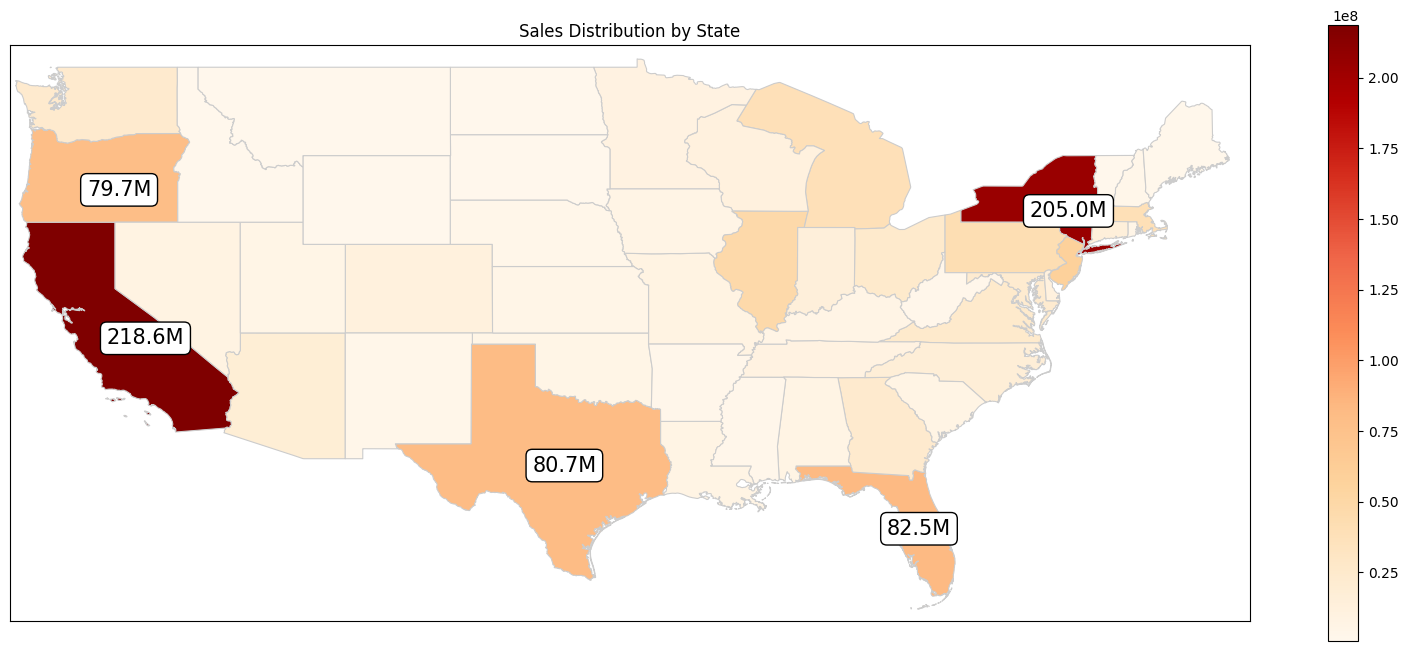

In [46]:
heat_map_dataset_grouped = heat_map_dataset.groupby('Buyer Region')
heat_map_dataset_grouped_sorted = heat_map_dataset_grouped.sum()[['Number of Sales']].sort_values('Number of Sales', ascending=False).reset_index()

gdf = gpd.read_file('ne_10m_admin_1_states_provinces.shp')
merged_data = pd.merge(gdf, heat_map_dataset_grouped_sorted, left_on='name', right_on='Buyer Region', how='right')

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
ax.set_xlim([-125, -66])
ax.set_ylim([24, 50])
merged_data.plot(column='Number of Sales', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

i = 0
for idx, row in merged_data.iterrows():
    plt.annotate(text=f'{readable_numbers(row["Number of Sales"])}',
                 xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                 xytext=(-12, -12),
                 textcoords='offset points',
                 color='black',
                 fontsize=15,
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
    i+=1
    if i == 6:
        break
ax.set_title('Sales Distribution by State')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [47]:
##Group by brand 
stockx_data_grouped = stockx_data.groupby('Brand_name')
stockx_data_sorted = stockx_data_grouped.sum()[['Number of Sales']].sort_values('Number of Sales', ascending=False).reset_index()
stockx_data_sorted.head()

,Brand_name,Number of Sales
0,yeezy,1176030690
1,airjordan,22041269
2,presto,9599230
3,zoom,7909957
4,airmax90,6336703


In [48]:
##Group by Colour 
stockx_data_grouped = stockx_data.groupby('Colour')
stockx_data_sorted = stockx_data_grouped.sum()[['Number of Sales']].sort_values('Number of Sales', ascending=False).reset_index()
stockx_data_sorted.head()

,Colour,Number of Sales
0,Colorful,589107113
1,White,400863005
2,Black,139693747
3,Grey,93752896
4,Pink,3901689


In [49]:
##Group by Brand and Colour 
stockx_data_grouped = stockx_data.groupby(['Brand_name', 'Colour'])
stockx_data_sorted = stockx_data_grouped.sum()[['Number of Sales']].sort_values('Number of Sales', ascending=False).reset_index()
stockx_data_sorted.head()

,Brand_name,Colour,Number of Sales
0,yeezy,Colorful,564471065
1,yeezy,White,392305818
2,yeezy,Black,122292346
3,yeezy,Grey,93455172
4,airjordan,Colorful,21929215


In [50]:
##Group by Shoe Size 
stockx_data_grouped = stockx_data.groupby('Shoe Size')
stockx_data_sorted = stockx_data_grouped.sum()[['Number of Sales']].sort_values('Number of Sales', ascending=False).reset_index()
stockx_data_sorted.head()

,Shoe Size,Number of Sales
0,10.0,123118485
1,11.0,111516425
2,9.0,110859278
3,9.5,109864365
4,10.5,109005484


In [51]:
## find the range of percentage price increase for each shoe in california, New York, Florida
def calculate_range(x):
    max_x = x.max()
    min_x = x.min()
    range_value = max_x - min_x
    return range_value 

_stockx_data = stockx_data[(stockx_data['Region'] == 'California') | (stockx_data['Region'] == 'New York') | (stockx_data['Region'] == 'Florida')]
_stockx_data_grouped = _stockx_data.groupby('Brand_name')['Price_Percentage_change'].apply(lambda x: calculate_range(x)).reset_index()
_stockx_data_grouped_sorted = _stockx_data_grouped.sort_values(by='Price_Percentage_change', ascending=False)
_stockx_data_grouped_sorted.head()

,Brand_name,Price_Percentage_change
1,airjordan,17.110526
5,presto,10.375000
4,blazer,9.515385
8,yeezy,9.111364
9,zoom,8.945000


### Descriptive Statistics

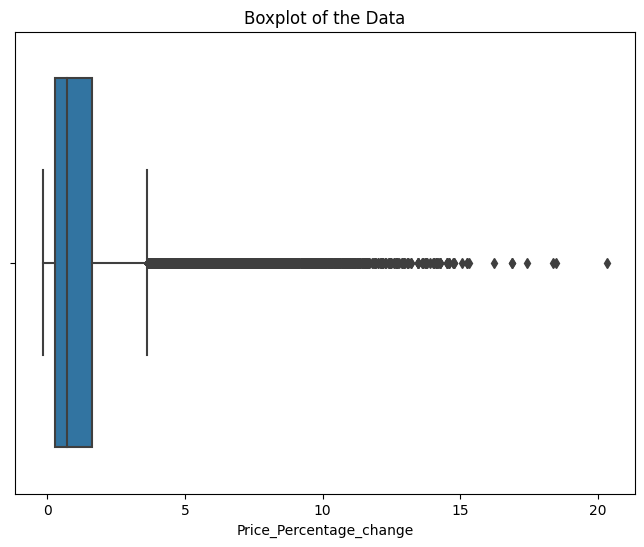

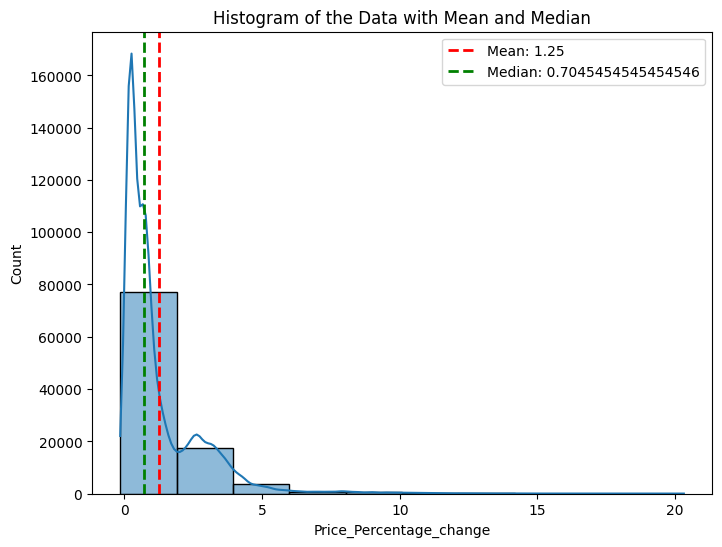

In [117]:
mean_value = stockx_data['Price_Percentage_change'].mean()
median_value = stockx_data['Price_Percentage_change'].median()
mode_value = stockx_data['Price_Percentage_change'].mode().iloc[0]
std_deviation = stockx_data['Price_Percentage_change'].std()

# Plot a boxplot to visualize the distribution
plt.figure(figsize=(8, 6))
sns.boxplot(x=stockx_data['Price_Percentage_change'])
plt.title('Boxplot of the Data')
plt.show()

# Plot a histogram for additional insight
plt.figure(figsize=(8, 6))
sns.histplot(stockx_data['Price_Percentage_change'], bins=10, kde=True)
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_value}')
plt.legend()
plt.title('Histogram of the Data with Mean and Median')
plt.show()

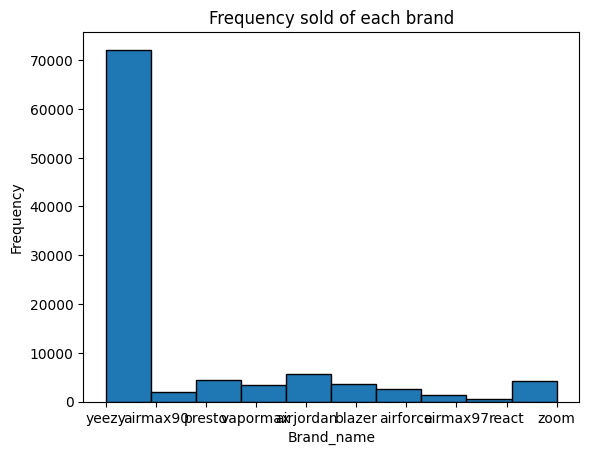

In [118]:
plt.hist(stockx_data['Brand_name'], edgecolor='black')

# Customize plot
plt.title('Frequency sold of each brand')
plt.xlabel('Brand_name')
plt.ylabel('Frequency')

# Show plot
plt.show()

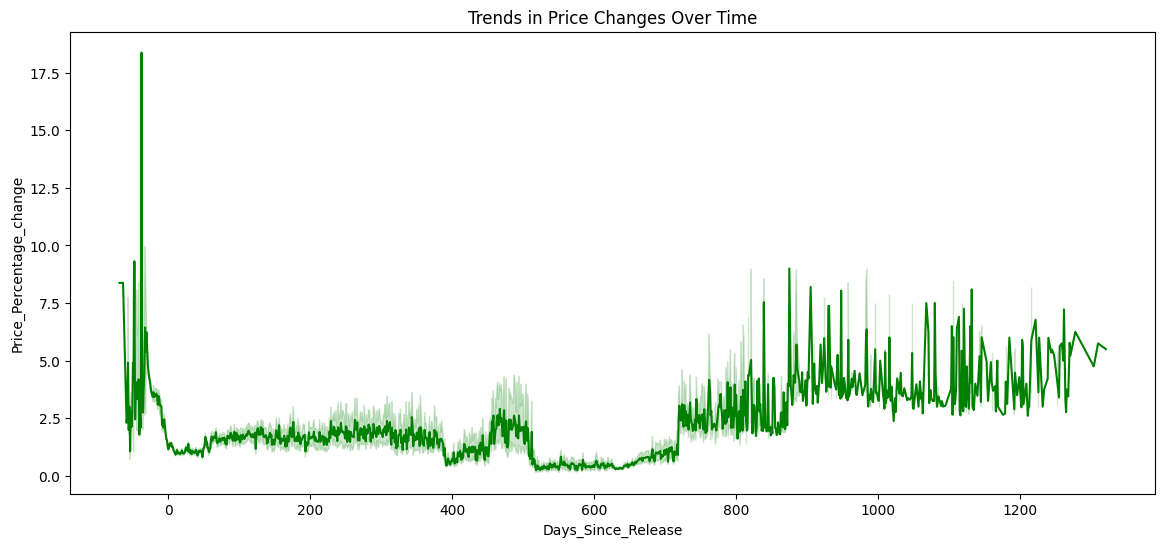

In [178]:
plt.figure(figsize=(14, 6))
sns.lineplot(x='Days_Since_Release', y='Price_Percentage_change', data=stockx_data, color='green')
plt.title('Trends in Price Changes Over Time')
plt.xlabel('Days_Since_Release')
plt.ylabel('Price_Percentage_change')
plt.show()

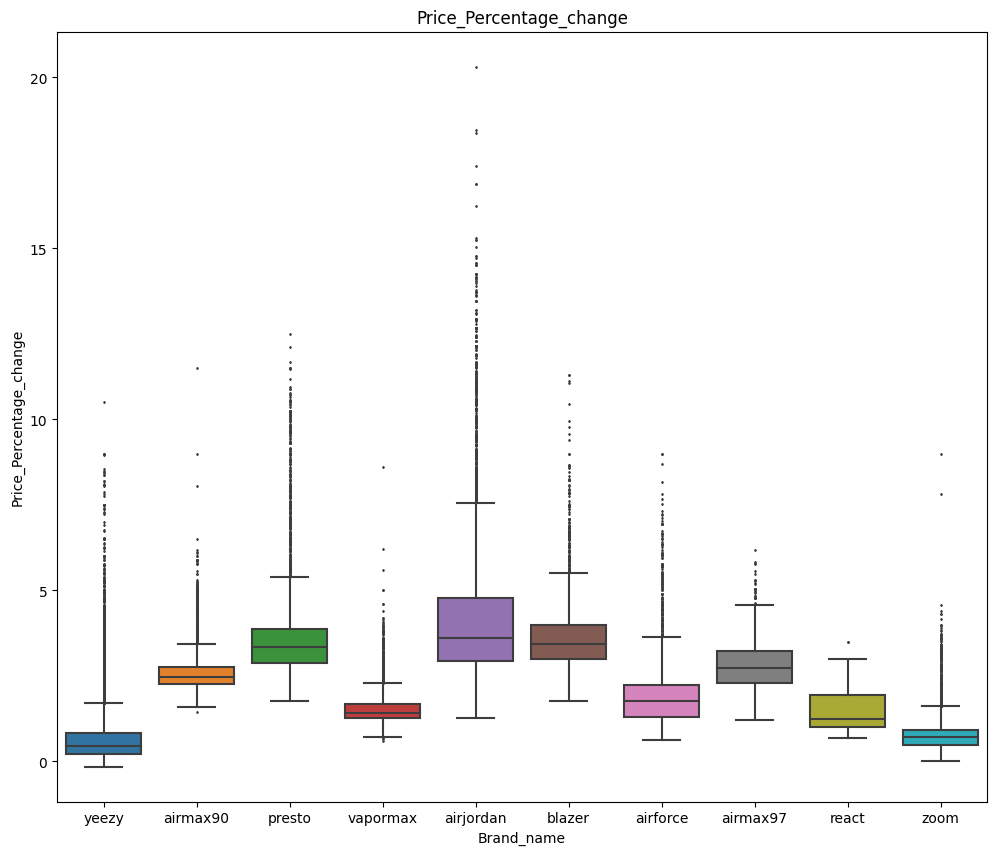

In [53]:
# Create box plot of Price_Percentage_change
plt.figure(figsize=(12,10))
plt.title('Price_Percentage_change')
sns.boxplot(x=stockx_data['Brand_name'],
            y=stockx_data['Price_Percentage_change'], fliersize=1);

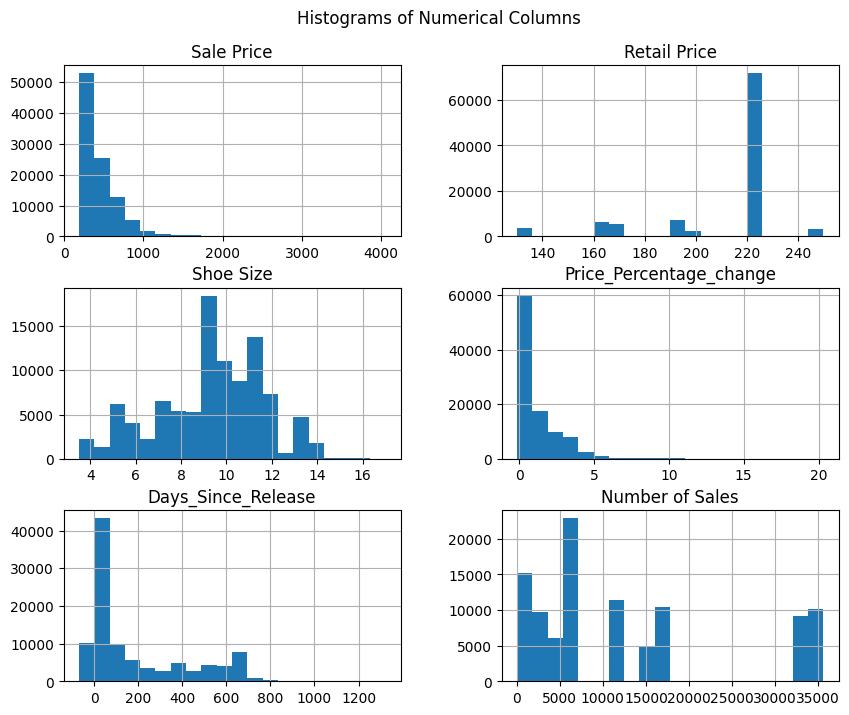

In [54]:
stockx_data.hist(bins=20, figsize=(10, 8))
plt.suptitle("Histograms of Numerical Columns", y=0.95)
plt.show()

### Correlation Analysis

In [56]:
stockx_data_subset = stockx_data.filter(items=['Shoe Size', 'Price_Percentage_change', 'Days_Since_Release', 'Number of Sales']) 
stockx_data_subset.corr()

,Shoe Size,Price_Percentage_change,Days_Since_Release,Number of Sales
Shoe Size,1.000000,0.082967,0.017450,-0.031384
Price_Percentage_change,0.082967,1.000000,-0.134612,-0.450242
Days_Since_Release,0.017450,-0.134612,1.000000,0.680277
Number of Sales,-0.031384,-0.450242,0.680277,1.000000


C:\Users\amees\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


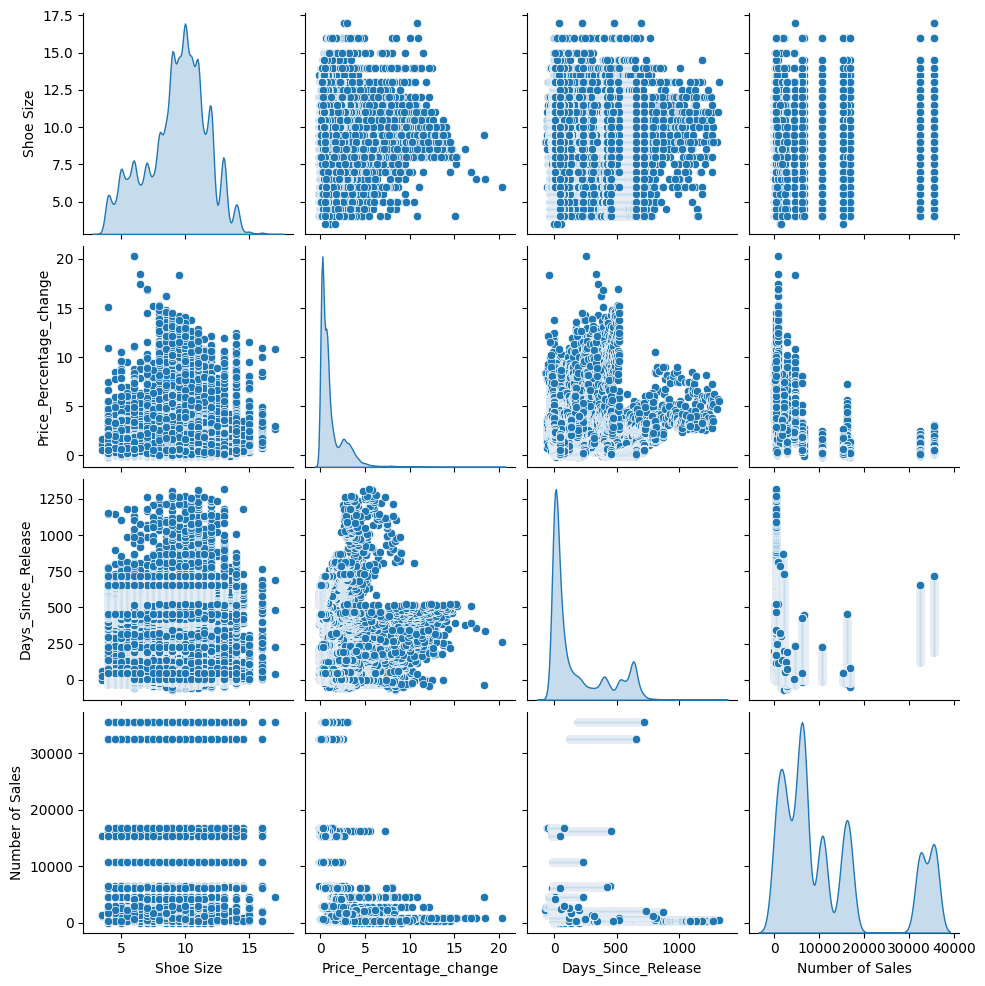

In [57]:
warnings.filterwarnings("ignore", category=FutureWarning)
sns.pairplot(stockx_data_subset, diag_kind='kde')

In [176]:
stockx_data

,Sale Price,Retail Price,Shoe Size,Price_Percentage_change,Days_Since_Release,Number of Sales,Brand_name,Region,Colour
0,1097.0,220,11.0,3.986364,342.0,1857,yeezy,California,Orange
1,685.0,220,11.0,2.113636,282.0,560,yeezy,California,Orange
2,690.0,220,11.0,2.136364,282.0,520,yeezy,California,Green
3,1075.0,220,11.5,3.886364,282.0,808,yeezy,Other States,Red
4,828.0,220,11.0,2.763636,202.0,2153,yeezy,Other States,Red
...,...,...,...,...,...,...,...,...,...
99951,565.0,220,8.0,1.568182,49.0,6085,yeezy,Oregon,White
99952,598.0,220,8.5,1.718182,49.0,6085,yeezy,California,White
99953,605.0,220,5.5,1.750000,49.0,6085,yeezy,New York,White
99954,650.0,220,11.0,1.954545,49.0,6085,yeezy,California,White


### K-means Clustering (Clustering-then-Predict)

In [119]:
stockx_data

,Sale Price,Retail Price,Shoe Size,Price_Percentage_change,Days_Since_Release,Number of Sales,Brand_name,Region,Colour
0,1097.0,220,11.0,3.986364,342.0,1857,yeezy,California,Orange
1,685.0,220,11.0,2.113636,282.0,560,yeezy,California,Orange
2,690.0,220,11.0,2.136364,282.0,520,yeezy,California,Green
3,1075.0,220,11.5,3.886364,282.0,808,yeezy,Other States,Red
4,828.0,220,11.0,2.763636,202.0,2153,yeezy,Other States,Red
...,...,...,...,...,...,...,...,...,...
99951,565.0,220,8.0,1.568182,49.0,6085,yeezy,Oregon,White
99952,598.0,220,8.5,1.718182,49.0,6085,yeezy,California,White
99953,605.0,220,5.5,1.750000,49.0,6085,yeezy,New York,White
99954,650.0,220,11.0,1.954545,49.0,6085,yeezy,California,White


In [160]:
X = stockx_data.drop('Price_Percentage_change', axis=1)  # Features
y = stockx_data['Price_Percentage_change']  # Target variable

# Split the data into training and test sets
# test_size specifies the proportion of the dataset to include in the test split
# random_state ensures reproducibility, so you get the same split every time you run the code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_subset_1 = X_train.filter(items=['Days_Since_Release', 'Number of Sales']) 
X_test_subset_1 = X_test.filter(items=['Days_Since_Release', 'Number of Sales']) 

#Apply log transformation
small_constant = 1e-8

X_train_subset_1_log = np.log1p(np.maximum(X_train_subset_1, small_constant))
X_test_subset_1_log = np.log1p(np.maximum(X_test_subset_1, small_constant))

#Scale data 
X_train_subset_1_scaled = scaler.fit_transform(X_train_subset_1_log)
X_test_subset_1_scaled = scaler.transform(X_test_subset_1_log)

#Convert scaled data to dataframe
X_train_subset_1_scaled = pd.DataFrame(X_train_subset_1_scaled, columns=X_train_subset_1.columns)
X_test_subset_1_scaled = pd.DataFrame(X_test_subset_1_scaled, columns=X_train_subset_1.columns)

In [161]:
# Baseline model: Predict the mean of the target variable for all instances
baseline_predictions = np.full_like(y_test, y_train.mean())

# Calculate the mean squared error for the baseline model
baseline_mse = mean_squared_error(y_test, baseline_predictions)

print(f"Baseline Mean Squared Error: {baseline_mse}")

Baseline Mean Squared Error: 2.2576652727487017


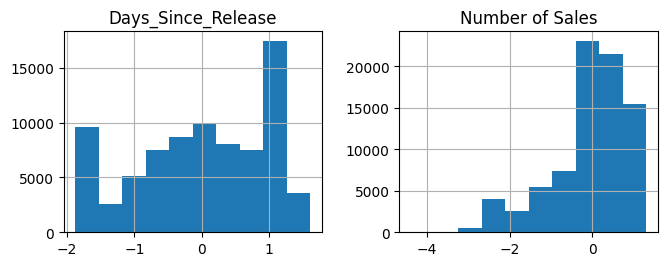

In [162]:
X_train_subset_1_scaled.hist(figsize=(12,6), layout=(2,3))
plt.show()

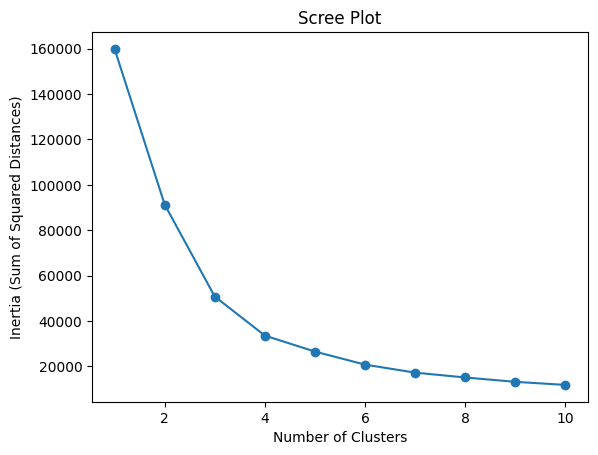

In [163]:
#Scree Plot to determine number of clusters k  
X_for_cluster_analysis = X_train_subset_1_scaled

# Define a range of cluster numbers to try
num_clusters_range = range(1, 11)

# Calculate inertia (sum of squared distances) for each cluster number
inertia = []
for num_clusters in num_clusters_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(X_for_cluster_analysis)
    inertia.append(kmeans.inertia_)

# Plot the scree plot
plt.plot(num_clusters_range, inertia, marker='o')
plt.title('Scree Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.show()

In [164]:
#Initialize K-means
clusters = 4
kmeans = KMeans(init='k-means++', n_clusters=clusters, n_init=10, max_iter=100, random_state=88)
cluster_assignments = kmeans.fit_predict(X_train_subset_1_scaled)

In [165]:
# Sum of squared distances of samples to their closest cluster center
kmeans.inertia_

33491.23822616174

In [166]:
# Number of iterations
kmeans.n_iter_

11

In [167]:
# Cluster for each datapoint
np.unique(kmeans.labels_)

array([0, 1, 2, 3])

In [168]:
# Cluster centroids
kmeans.cluster_centers_

array([[-1.38435095, -0.10879643],
       [ 1.13903139,  1.16477713],
       [ 0.35035734, -1.74638547],
       [ 0.07825621,  0.06696919]])

In [169]:
models = {}
for cluster_id in range(clusters):
    # Filter data points belonging to the current cluster
    cluster_subset = X_train_subset_1_scaled[cluster_assignments == cluster_id]
    y_cluster = y_train[cluster_assignments == cluster_id]

    # Check if the cluster subset is not empty
    if np.any(cluster_subset > 0):
        model = LinearRegression()
        model.fit(cluster_subset, y_cluster)
        models[cluster_id] = model
    else:
        print(f"Cluster {cluster_id} is empty.")

# Predictions on the training set
train_predictions = np.zeros_like(y_train)

for cluster_id in range(clusters):
    # Filter training data points belonging to the current cluster
    cluster_indices = np.where(cluster_assignments == cluster_id)[0]

    if cluster_id in models and len(cluster_indices) > 0:
        # Extract features for the current cluster
        cluster_features = X_train_subset_1_scaled.iloc[cluster_indices]

        # Use the corresponding model for prediction
        cluster_predictions = models[cluster_id].predict(cluster_features)

        # Update training predictions at the corresponding indices
        train_predictions[cluster_indices] = cluster_predictions

# Calculate R-squared for the training set
training_r2 = r2_score(y_train, train_predictions)

print(f"Training R-squared: {training_r2}")

Training R-squared: 0.4884337177730471


C:\Users\amees\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


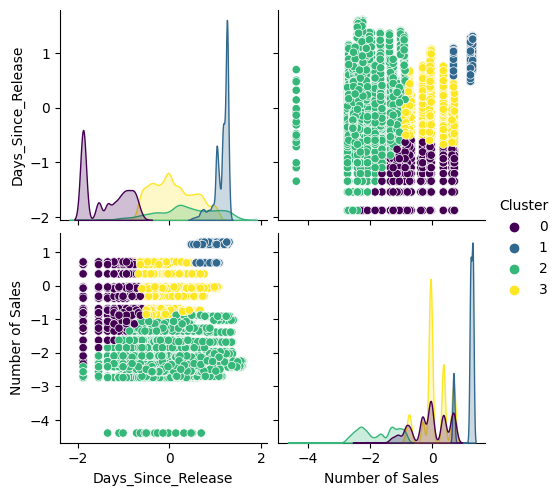

In [170]:
df_with_clusters = X_train_subset_1_scaled.copy()
df_with_clusters['Cluster'] = cluster_assignments

# Create a scatter pairplot with hue=Cluster
sns.pairplot(df_with_clusters, hue='Cluster', palette='viridis')
plt.show()

In [171]:
test_cluster_assignments = kmeans.predict(X_test_subset_1_scaled)
test_predictions = np.zeros_like(y_test)

for cluster_id in range(clusters):
    # Filter test data points belonging to the current cluster
    cluster_indices = np.where(test_cluster_assignments == cluster_id)[0]

    if cluster_id in models and len(cluster_indices) > 0:
        # Extract features for the current cluster
        cluster_features = X_test_subset_1_scaled.iloc[cluster_indices]

        # Use the corresponding model for prediction
        cluster_predictions = models[cluster_id].predict(cluster_features)

        # Update test predictions at the corresponding indices
        test_predictions[cluster_indices] = cluster_predictions
    elif len(cluster_indices) == 0:
        print(f"Warning: No test data points for cluster {cluster_id}.")
    else:
        print(f"Warning: Model not found for cluster {cluster_id}.")

r2_out_of_sample = r2_score(y_test, test_predictions)

print(f"Out-of-Sample R-squared: {r2_out_of_sample}")

Out-of-Sample R-squared: 0.4882096925469176


In [172]:
mse = mean_squared_error(y_test, test_predictions)
print(f'Mean Squared Error on Test Set: {mse}')

Mean Squared Error on Test Set: 1.1552690929306215


In [173]:
target_range = np.max(y_test) - np.min(y_test)
rmse = np.sqrt(mse)

rmse_percentage = (rmse / target_range) * 100

print("RMSE Percentage:", rmse_percentage)

RMSE Percentage: 7.770469909817439
